In [8]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
#from tqdm import tqdm

In [9]:
DATADIR = "hack_data_lenta" # "./data"
clients = pd.read_csv(f"{DATADIR}/clients.csv")
materials = pd.read_csv(f"{DATADIR}/materials.csv")
plants = pd.read_csv(f"{DATADIR}/plants.csv")

In [10]:
transactions = pd.read_parquet(f"{DATADIR}/transactions.parquet")

In [11]:
transactions['date'] = pd.to_datetime(transactions.chq_date)
transactions['year'] = transactions['date'].dt.year 
transactions['month'] = transactions['date'].dt.month 

In [12]:
uniq_chq = transactions.chq_id.unique()
dict_uniq_chq = dict(zip(uniq_chq,range(len(uniq_chq))))
def dict_chq(x):
    return dict_uniq_chq[x]
transactions['chq_id_cat'] = transactions.chq_id.apply(dict_chq)

In [13]:
uniq_mat = transactions.material.unique()
dict_uniq_mat = dict(zip(uniq_mat,range(len(uniq_mat))))
def dict_mat(x):
    return dict_uniq_mat[x]
transactions['material_cat'] = transactions.material.apply(dict_mat)

In [14]:
uniq_clt = transactions.client_id.unique()
dict_uniq_clt = dict(zip(uniq_clt,range(len(uniq_clt))))
def dict_clt(x):
    return dict_uniq_clt[x]
transactions['client_id_cat'] = transactions.client_id.apply(dict_clt)

In [15]:
uniq_plt = transactions.plant.unique()
dict_uniq_plt = dict(zip(uniq_plt,range(len(uniq_plt))))
def dict_plt(x):
    return dict_uniq_plt[x]
transactions['plant_cat'] = transactions.plant.apply(dict_plt)

In [16]:
data = transactions.drop(['chq_id', 'plant', 'chq_date', 'client_id', 'material'], axis=1)

In [17]:
data.head(7)

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
5,001,2.000,64.78,1,2016-11-01,2016,11,0,4,0,0
6,006,0.728,65.51,0,2016-11-01,2016,11,0,5,0,0


In [26]:
cherry_picker = data.groupby(['client_id_cat'])['is_promo'].sum() 

In [18]:
all_ = data.groupby(['client_id_cat'])['is_promo'].count() 
all_ = all_[all_ > 200].index

In [27]:
client_id_cp = cherry_picker[cherry_picker > 200].index

In [32]:
len(client_id_cp), len(all_)

(24771, 48012)

In [19]:
all_ind = [i in all_ for i in data.client_id_cat]
data_all = data[all_ind]

In [20]:
data_all

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109409,003,0.795,215.44,1,2016-10-31,2016,10,2964773,43155,2913,187
32109410,001,1.840,34.94,1,2016-10-31,2016,10,2964774,680,64170,187
32109411,003,1.710,32.47,1,2016-10-31,2016,10,2964774,680,64170,187
32109412,004,1.000,21.10,0,2016-10-31,2016,10,2964774,35138,64170,187


In [35]:
data_all['sales_sum'].sum()

3341384613.9800043

In [20]:
cp_mat_ind = [i in client_id_cp for i in data.client_id_cat]
data_cp = data[cp_mat_ind]

In [21]:
data_cp

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109405,010,1.000,217.99,0,2016-10-31,2016,10,2964773,24686,2913,187
32109406,006,1.000,161.09,0,2016-10-31,2016,10,2964773,10409,2913,187
32109407,002,1.000,3.49,0,2016-10-31,2016,10,2964773,14,2913,187
32109408,011,1.000,99.99,1,2016-10-31,2016,10,2964773,14625,2913,187


In [23]:
data_notcp = data[~(np.array(cp_mat_ind))]

In [26]:
data_notcp['sales_sum'].sum()

1510645144.02

In [27]:
data_cp['sales_sum'].sum()

2435183442.789998

In [25]:
20127822/(11981592+20127822)

0.6268511159998124

In [28]:
2435183442.789998/(2435183442.789998+1510645144.02)

0.6171538852271128

In [36]:
2435183442.789998/(3341384613.9800043)

0.728794713605086

In [21]:
promo_ = data.groupby(['client_id_cat'])['is_promo'].sum()

In [22]:
all_ = data.groupby(['client_id_cat'])['is_promo'].count()

In [23]:
promo_ = promo_.reset_index()
all_ = all_.reset_index()
promo_ = promo_.merge(all_, on=['client_id_cat'], how='left')

In [24]:
promo_['procent_promo'] = promo_.is_promo_x/promo_.is_promo_y

In [28]:
promo_cp = [i in client_id_cp for i in promo_.client_id_cat]

In [29]:
promo_

,client_id_cat,is_promo_x,is_promo_y,procent_promo
0,0,366,688,0.531977
1,1,116,394,0.294416
2,2,68,155,0.438710
3,3,488,879,0.555176
4,4,560,1452,0.385675
...,...,...,...,...
99995,99995,1,5,0.200000
99996,99996,4,16,0.250000
99997,99997,16,40,0.400000
99998,99998,16,55,0.290909


In [30]:
more_40 = promo_[promo_cp][promo_[promo_cp].procent_promo > 0.4].client_id_cat.index
more_70 = promo_[promo_cp][promo_[promo_cp].procent_promo > 0.7].client_id_cat.index

In [31]:
promo_cp70 = [i in more_70 for i in data.client_id_cat]

In [32]:
data[promo_cp70]

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
1521,009,1.0,29.99,1,2016-11-01,2016,11,128,1020,107,2
1522,002,2.0,65.98,1,2016-11-01,2016,11,128,1092,107,2
1523,010,1.0,17.99,1,2016-11-01,2016,11,128,1093,107,2
1524,013,1.0,1998.64,1,2016-11-01,2016,11,128,1094,107,2
1525,008,1.0,32.99,1,2016-11-01,2016,11,128,1095,107,2
...,...,...,...,...,...,...,...,...,...,...,...
32109224,003,1.0,69.86,1,2016-10-31,2016,10,2964738,3003,61111,183
32109269,002,1.0,259.03,1,2016-10-31,2016,10,2964749,298,17507,183
32109270,004,1.0,37.99,1,2016-10-31,2016,10,2964749,1086,17507,183
32109271,001,1.0,37.99,1,2016-10-31,2016,10,2964749,1086,17507,183


In [98]:
data['sales_sum'].sum()

3945828586.8100038

In [62]:
data[promo_cp70]['sales_sum'].sum()

159865628.24

In [65]:
159865628.24/2435183442

0.0656482897685537

In [66]:
1289024/20127822

0.06404190180139709

In [33]:
c1 = promo_[promo_cp].procent_promo > 0.4
c2 = promo_[promo_cp].procent_promo < 0.7

more_40_less70 = promo_[promo_cp][c1&c2].client_id_cat.index

In [34]:
promo_cp40_70 = [i in more_40_less70 for i in data.client_id_cat]

In [35]:
data[promo_cp40_70]

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109383,004,1.000,47.49,0,2016-10-31,2016,10,2964769,1721,27143,185
32109384,002,1.000,32.99,1,2016-10-31,2016,10,2964767,1185,27143,185
32109385,002,1.000,50.89,0,2016-10-31,2016,10,2964769,4896,27143,185
32109386,003,1.222,23.21,1,2016-10-31,2016,10,2964769,680,27143,185


In [101]:
data

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109409,003,0.795,215.44,1,2016-10-31,2016,10,2964773,43155,2913,187
32109410,001,1.840,34.94,1,2016-10-31,2016,10,2964774,680,64170,187
32109411,003,1.710,32.47,1,2016-10-31,2016,10,2964774,680,64170,187
32109412,004,1.000,21.10,0,2016-10-31,2016,10,2964774,35138,64170,187


In [72]:
data[promo_cp40_70]['sales_sum'].sum()

1744908681.5199976

In [102]:
14714579/32109414, 18734/99995,  1744908681.5199976/3945828586.8100038  #from all

(0.45826370422082446, 0.1873493674683734, 0.4422160372989403)

In [100]:
14714579/27413419, 1744908681.5199976/3341384613.9800043  #from all_

(0.5367655526660137, 0.5222112636239127)

In [74]:
14714579/20127822, 1744908681.5199976/2435183442.789998 #from cp200_

(0.7310566935657519, 0.7165409598551022)

In [37]:
clients['client_id_cat'] = clients.client_id.apply(dict_clt)

In [38]:
clients

,client_id,gender,city,birthyear,client_id_cat
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0,56771
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0,56386
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0,96019
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0,56249
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0,16994
...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,M,Other,1985.0,4484
99991,e261c97d40ab839926c712b4aa6cefd8,F,St. Petersburg,1982.0,1074
99992,678ef46f41f8c89f7e8578c9e9592e3e,M,Other,1964.0,77456
99993,274facf0609ceba803f5853bd2222208,F,Other,1951.0,56796


In [39]:
clients_cp40_70 = [i in more_40_less70 for i in clients.client_id_cat]
clients_cp40_70 = clients[clients_cp40_70]

In [86]:
clients_cp40_70.birthyear.describe()

count    18528.000000
mean      1976.225497
std         13.520667
min       1900.000000
25%       1967.000000
50%       1979.000000
75%       1987.000000
max       2009.000000
Name: birthyear, dtype: float64

In [87]:
clients.birthyear.describe()

count    98219.000000
mean      1975.125963
std         14.964637
min       1900.000000
25%       1964.000000
50%       1977.000000
75%       1987.000000
max       2049.000000
Name: birthyear, dtype: float64

In [88]:
clients_cp40_70.city.value_counts()

Other             14556
St. Petersburg     3325
Moscow              853
Name: city, dtype: int64

In [89]:
clients.city.value_counts()

Other             81207
St. Petersburg    13374
Moscow             5414
Name: city, dtype: int64

In [90]:
clients_cp40_70.gender.value_counts()

F    11189
M     7512
Name: gender, dtype: int64

In [91]:
clients.gender.value_counts()

F    59280
M    40360
Name: gender, dtype: int64

In [94]:
data[promo_cp40_70].client_id_cat.nunique()

18736

In [41]:
clients_cp40_70

,client_id,gender,city,birthyear,client_id_cat
8,e2f21dcfe01938a1bf74dc993715c22f,F,Other,1984.0,21308
14,beef839c703bdbd1cfc1c5454732fb50,M,Moscow,1993.0,52686
24,9e7249dd52883fe4fc3cb9f3b26f55cf,M,St. Petersburg,1957.0,54306
31,4650959158cf97a3239bbfd362aa78ef,M,Other,1989.0,83946
36,5fb926087ba1353d1cefdacd170228f1,M,Other,1989.0,77375
...,...,...,...,...,...
99954,2806010f75ad3fc79caa379be60bd4ba,M,Other,1973.0,26799
99955,44185021e56c357c10d4dc716f5bc92a,F,Other,1968.0,35977
99966,f1e563eab9a7df1ce0cc463462054124,M,St. Petersburg,1997.0,24426
99989,1daaf7a4ee2df1b5aeeb8eb42fcea4d7,M,Other,1990.0,24615


In [103]:
data

,chq_position,sales_count,sales_sum,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32109409,003,0.795,215.44,1,2016-10-31,2016,10,2964773,43155,2913,187
32109410,001,1.840,34.94,1,2016-10-31,2016,10,2964774,680,64170,187
32109411,003,1.710,32.47,1,2016-10-31,2016,10,2964774,680,64170,187
32109412,004,1.000,21.10,0,2016-10-31,2016,10,2964774,35138,64170,187


In [42]:
date = [(2016,10), (2016,11), (2016,12), (2017,1), (2017,2), (2017,3), (2017,4), (2017,5), (2017,6), (2017,7), (2017,8), (2017,9), (2017,10)]

In [43]:
data40_70 = data[promo_cp40_70]

In [44]:
clients_40_70 = clients_cp40_70.client_id_cat.values
sum_40_70 = np.array([[0] * len(date)] * len(clients_40_70))

In [144]:
num_checked = i
sum_40_70_checked = sum_40_70[:i]

In [146]:
sum_40_70_checked, num_checked

(array([[ 443,  288,  562, ...,  498,  294,  220],
        [   0, 1231,  182, ..., 1372,    0,    0],
        [2891, 1425, 1279, ..., 4161, 2987,    0],
        ...,
        [3718, 2317, 1982, ...,    0, 2208,    0],
        [   0,    0,  217, ...,  373,  487,  433],
        [1303, 1194, 1141, ...,  706,    0,    0]]), 2887)

In [45]:
gp = data40_70.groupby(['client_id_cat', 'chq_id_cat'])['sales_sum'].sum().reset_index()

In [46]:
data40_70 = data40_70.merge(gp, how='left', on=['client_id_cat', 'chq_id_cat'])

In [47]:
temp = data40_70.drop_duplicates(subset=['chq_id_cat'])

In [48]:
gp = temp.groupby(['client_id_cat','year', 'month'])['sales_sum_y'].mean().reset_index()
gp = gp.rename(columns={'sales_sum_y':'sales_aver_month'})

In [49]:
data40_70 = data40_70.merge(gp, how='left', on = ['client_id_cat','year', 'month'])

In [50]:
data40_70 = data40_70.drop(['sales_aver_month_x'], axis=1)

KeyError: "['sales_aver_month_x'] not found in axis"

In [190]:
data40_70.to_csv('lenta_data40_70')

In [87]:
cond1 = data40_70.date <= pd.to_datetime('2017-08-21')
cond2 = data40_70.date > pd.to_datetime('2017-08-14')
data_12 = data40_70[cond1&cond2]

In [72]:
data_12_full = data40_70[cond1]

In [73]:
count_clt = data_12_full['client_id_cat'].value_counts()
data_12 = data_12_full.sort_values(by=['client_id_cat'])
term = data_12_full.drop_duplicates(subset=['client_id_cat'])
id_data40_70 = term['client_id_cat'].values

In [66]:
from tqdm import tqdm

In [75]:
al_sm = 0
a = np.array([[0]*5]*len(id_data40_70))
for i, id_ in enumerate(id_data40_70):
    count_id = count_clt[id_]
    a[i] = data40_70[al_sm:al_sm+count_id].material_cat.value_counts()[:5].index
    al_sm += count_id

In [76]:
a

array([[  114,    14,     2,    51,    44],
       [   14,   114,  1518,    44,   727],
       [   14,  1518,    44,   861,     2],
       ...,
       [17470, 13055, 21805,   727,    14],
       [   14,  3304,   322,    44, 25206],
       [  727,    14,  3148,    44, 10851]])

In [91]:
first_50 = id_data40_70[:50]


# Suggest discount in case of absence

In [ ]:
for i, id_ in enumerate(first_50):
    data_12_clt = data_12[data_12.client_id_cat == id_]
    plant = data_12_clt.plant_cat.unique()
    for mat_cat in a[i]:
        if(data_12[data_12['material_cat'] == mat_cat].date.nunique() < 7 ):
        #suggest discount
            hl4 = materials[materials['material_cat'] == mat_cat].hier_level_4
            replace = list(materials[materials['hier_level_4'] == hl4.reset_index()['hier_level_4'][0]].material_cat)
            for elem in replace:
                cond1 = cat_boost1.material_cat == elem
                cond2 = cat_boost1.plant_cat == plant[0]
                cond3 = cat_boost1.date == pd.to_datetime(f'21/08/2017')
                if (elem != mat_cat and cat_boost1[cond1&cond2&cond3]['elasticity_reaction'] == 0):
                    print(f'Suggest client {id_} a discount for material {elem} in store {plant[0]} a 10% discount')
                    el = cat_boost1[cond1&cond2&cond3]['elasticity']
                    margin = cat_boost1[cond1&cond2&cond3]


In [99]:
materials['material_cat'] = materials.material.apply(dict_mat)

In [124]:
hl4 = materials[materials['material_cat'] == 114].hier_level_4
list(materials[materials['hier_level_4'] == hl4.reset_index()['hier_level_4'][0]].material_cat)

[1518, 114, 90570, 29499, 68383, 14, 727, 8610, 1102]

In [117]:
hl4.reset_index()['hier_level_4'][0]

'5bf563e8f99ed820f322704e4898df6b'

In [92]:
plant = data_12[data_12.client_id_cat == first_50[0]].plant_cat.unique()

In [96]:
data_12[data_12['material_cat'] == a[0][0]].date.nunique()

7

In [93]:
data_12[data_12.client_id_cat == first_50[0]]

,chq_position,sales_count,sales_sum_x,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat,sales_sum_y,sales_aver_month
12815246,009,0.246,63.96,0,2017-08-19,2017,8,2565333,69129,0,0,1879.0,2408.333333
12815247,014,0.940,61.09,1,2017-08-19,2017,8,2565333,2556,0,0,1879.0,2408.333333
12815248,020,2.000,108.68,1,2017-08-19,2017,8,2565333,22874,0,0,1879.0,2408.333333
12815249,018,1.000,66.09,0,2017-08-19,2017,8,2565333,11,0,0,1879.0,2408.333333
12815250,001,1.000,47.89,0,2017-08-19,2017,8,2565333,16418,0,0,1879.0,2408.333333
12815251,008,0.436,43.60,1,2017-08-19,2017,8,2565333,451,0,0,1879.0,2408.333333
12815252,017,0.668,30.05,1,2017-08-19,2017,8,2565333,593,0,0,1879.0,2408.333333
12815253,016,1.000,48.99,1,2017-08-19,2017,8,2565333,3021,0,0,1879.0,2408.333333
12815254,011,2.000,63.78,0,2017-08-19,2017,8,2565333,4428,0,0,1879.0,2408.333333
12815255,019,1.000,54.89,0,2017-08-19,2017,8,2565333,6865,0,0,1879.0,2408.333333


In [51]:
cat_boost = pd.read_csv('catboost.csv')

In [54]:
cat_boost[pd.to_datetime(cat_boost.date) > pd.to_datetime('2017-08-21')]

,Unnamed: 0,material_cat,date,plant_cat,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat,date_next,elasticity_reaction
2124850,9318302,29997,2017-08-28,132,8,0,2,0,1.0,0.0,0.0,1198.0,2017-09-04,0
2124851,9318303,3184,2017-08-28,22,8,1,2,0,0.0,0.0,0.0,17.0,2017-09-04,0
2124852,9318304,1209,2017-08-28,365,8,0,1,1,1.0,0.0,1.0,684.0,2017-09-04,1
2124853,9318305,3184,2017-08-28,15,8,1,2,0,0.0,0.0,0.0,17.0,2017-09-04,1
2124854,9318306,16599,2017-08-28,196,8,1,2,0,1.0,0.0,0.0,797.0,2017-09-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356961,10465761,44,2017-10-02,48,10,0,2,0,1.0,0.0,0.0,281.0,2017-10-09,0
2356962,10465782,44,2017-10-02,47,9,0,2,0,1.0,0.0,0.0,281.0,2017-10-09,0
2356963,10465802,283,2017-10-02,94,10,0,2,0,1.0,0.0,1.0,785.0,2017-10-09,0
2356964,10465819,12362,2017-10-02,93,9,1,1,0,1.0,0.0,0.0,492.0,2017-10-09,0


In [58]:
cat_boost1 = pd.read_csv('catboost_1.csv')

In [59]:
cat_boost1[pd.to_datetime(cat_boost.date) > pd.to_datetime('2017-08-21')]

,Unnamed: 0,material_cat,date,plant_cat,month,is_promo,plant_city,plant_type,product_type,is_alco,is_private_label,vendor_cat,elasticity,elasticity_reaction
2124850,9318302,29997,2017-08-28,132,8,0,2,0,1.0,0.0,0.0,1198.0,0.0,0
2124851,9318303,3184,2017-08-28,22,8,1,2,0,0.0,0.0,0.0,17.0,0.0,0
2124852,9318304,1209,2017-08-28,365,8,0,1,1,1.0,0.0,1.0,684.0,34.343434343434275,1
2124853,9318305,3184,2017-08-28,15,8,1,2,0,0.0,0.0,0.0,17.0,1.7976931348623157e+308,1
2124854,9318306,16599,2017-08-28,196,8,1,2,0,1.0,0.0,0.0,797.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356961,10465761,44,2017-10-02,48,10,0,2,0,1.0,0.0,0.0,281.0,-1.7976931348623157e+308,0
2356962,10465782,44,2017-10-02,47,9,0,2,0,1.0,0.0,0.0,281.0,-1.7976931348623157e+308,0
2356963,10465802,283,2017-10-02,94,10,0,2,0,1.0,0.0,1.0,785.0,-1.7976931348623157e+308,0
2356964,10465819,12362,2017-10-02,93,9,1,1,0,1.0,0.0,0.0,492.0,-1.7976931348623157e+308,0


In [178]:
date_start = pd.to_datetime(f'4/10/2016')
date_finish = []
for y, m in date[1:]:
    date_finish.append(pd.to_datetime(f'4/{m}/{y}'))

In [179]:
date_finish

[Timestamp('2016-04-11 00:00:00'),
 Timestamp('2016-04-12 00:00:00'),
 Timestamp('2017-04-01 00:00:00'),
 Timestamp('2017-04-02 00:00:00'),
 Timestamp('2017-04-03 00:00:00'),
 Timestamp('2017-04-04 00:00:00'),
 Timestamp('2017-04-05 00:00:00'),
 Timestamp('2017-04-06 00:00:00'),
 Timestamp('2017-04-07 00:00:00'),
 Timestamp('2017-04-08 00:00:00'),
 Timestamp('2017-04-09 00:00:00'),
 Timestamp('2017-04-10 00:00:00')]

In [194]:
gp

,client_id_cat,year,month,sales_aver_month
0,0,2016,10,724.000000
1,0,2016,11,1606.500000
2,0,2016,12,912.666667
3,0,2017,1,1245.000000
4,0,2017,2,1074.750000
...,...,...,...,...
213525,98350,2017,3,12220.000000
213526,98350,2017,4,1063.000000
213527,98350,2017,5,9014.000000
213528,98350,2017,6,8727.333333


In [198]:
mat_cl = data40_70.groupby(['client_id_cat','material_cat'])['sales_count'].count()
mat_cl = mat_cl.reset_index().rename({'sales_count':'clt_mat_count'})
data40_70 = data40_70.merge(mat_cl, how='left', on = ['client_id_cat','material_cat'])

In [200]:
data40_70 = data40_70.rename(columns={'sales_count_y':'clt_mat_count'})

In [201]:
data40_70.groupby['client_id_cat','material_cat']

,chq_position,sales_count_x,sales_sum_x,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat,sales_sum_y,sales_aver_month_y,clt_mat_count
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0,1634.0,1606.500000,21
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0,1634.0,1606.500000,1
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0,1634.0,1606.500000,16
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0,1634.0,1606.500000,16
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0,1634.0,1606.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14714574,004,1.000,47.49,0,2016-10-31,2016,10,2964769,1721,27143,185,559.0,891.888889,1
14714575,002,1.000,32.99,1,2016-10-31,2016,10,2964767,1185,27143,185,105.0,891.888889,1
14714576,002,1.000,50.89,0,2016-10-31,2016,10,2964769,4896,27143,185,559.0,891.888889,26
14714577,003,1.222,23.21,1,2016-10-31,2016,10,2964769,680,27143,185,559.0,891.888889,4


In [207]:
data40_70.groupby(['date'])['is_promo'].sum()

date
2016-10-04    12057
2016-10-05    12220
2016-10-06    11957
2016-10-07    14638
2016-10-08    19868
              ...  
2017-09-30    23912
2017-10-01    20958
2017-10-02    16533
2017-10-03    14483
2017-10-04    16325
Name: is_promo, Length: 366, dtype: int64

In [208]:
import seaborn as sns

In [214]:
import matplotlib.pyplot as plt

In [224]:
gp = data40_70.groupby(['date'])['is_promo'].sum()
gp[gp > 30000]

date
2016-12-04    33819
2016-12-05    32005
2016-12-10    30114
2016-12-11    37732
2016-12-17    31943
2016-12-18    41465
2016-12-19    31823
2016-12-24    32805
2016-12-25    41380
2016-12-26    34103
2016-12-31    32766
2017-01-01    36796
2017-01-08    32544
2017-01-15    35811
2017-02-05    32761
2017-02-12    34563
2017-02-19    36005
2017-02-26    32933
2017-03-05    36242
2017-03-12    33000
2017-03-18    32176
2017-03-19    41245
2017-03-26    39303
2017-03-27    31684
2017-04-01    34323
2017-04-02    45317
2017-04-03    46565
2017-04-04    41537
2017-04-16    32938
2017-04-23    40972
2017-04-29    32021
2017-04-30    37313
2017-05-06    32891
2017-05-07    30398
2017-05-14    31650
2017-05-21    31073
2017-05-28    33399
2017-06-04    30815
2017-06-10    31378
2017-06-11    36707
2017-06-18    33390
2017-07-01    32131
2017-07-22    33454
2017-07-23    33697
Name: is_promo, dtype: int64

In [256]:
data40_70['week'] = data40_70.date.dt.week

In [266]:
gp44 = data40_70[data40_70['week'] == 44].groupby(['material_cat', 'plant_cat'])['sales_sum_x', 'sales_count_x'].sum().reset_index()

In [270]:
gp44['mean_price44'] = gp44['sales_sum_x']/gp44['sales_count_x']
gp44 = gp44.rename(columns={'sales_sum_x':'sales_sum_44', 'sales_count_x':'sales_count_44'})

In [262]:
gp43 = data40_70[data40_70['week'] == 43].groupby(['material_cat', 'plant_cat'])['sales_sum_x', 'sales_count_x'].sum().reset_index()

In [264]:
gp43['mean_price'] = gp43['sales_sum_x']/gp43['sales_count_x']

In [272]:
gp43_44 = gp43.merge(gp44, how='left', on=['material_cat', 'plant_cat'])

In [274]:
gp43_44['proc_price'] = (gp43_44['mean_price44']-gp43_44['mean_price'])/(gp43_44['mean_price'])*100


In [276]:
gp43_44['proc_sales'] = (gp43_44['sales_count_44']-gp43_44['sales_count_x'])/(gp43_44['sales_count_x'])*100

In [278]:
gp43_44['Elasticity'] = gp43_44['proc_sales']/gp43_44['proc_price']

In [283]:
gp43_44['Elasticity'] = gp43_44['Elasticity'].fillna(0).astype(float)

In [287]:
gp43_44['Elasticity']==np.inf

0          True
1         False
2          True
3          True
4         False
          ...  
177706    False
177707    False
177708    False
177709    False
177710    False
Name: Elasticity, Length: 177711, dtype: bool

In [292]:
inf_id = gp43_44['Elasticity']==np.inf
mininf_id = gp43_44['Elasticity']==-np.inf
gp43_44['Elasticity'][inf_id] = [0]*len(gp43_44['Elasticity']==-np.inf)
gp43_44['Elasticity'][mininf_id] = [0]*len(gp43_44['Elasticity']==-np.inf)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [294]:
gp43_44['Elasticity'][inf_id] = [max(gp43_44['Elasticity'])]*len(inf_id)
gp43_44['Elasticity'][mininf_id] = [min(gp43_44['Elasticity'])]*len(mininf_id)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [346]:
gp43_44

,material_cat,plant_cat,sales_sum_x,sales_count_x,mean_price,sales_sum_44,sales_count_44,mean_price44,proc_price,proc_sales,Elasticity
0,0,0,734.90,10.0,73.49,808.39,11.0,73.49000,0.000000,10.000000,1.592388e+17
1,0,1,220.47,3.0,73.49,587.61,8.0,73.45125,-0.052728,166.666667,-3.160860e+03
2,0,3,367.45,5.0,73.49,440.94,6.0,73.49000,0.000000,20.000000,1.592388e+17
3,0,50,146.98,2.0,73.49,587.92,8.0,73.49000,0.000000,300.000000,1.592388e+17
4,0,52,440.94,6.0,73.49,719.48,10.0,71.94800,-2.098245,66.666667,-3.177259e+01
...,...,...,...,...,...,...,...,...,...,...,...
177706,105654,292,29.97,3.0,9.99,NaN,NaN,NaN,NaN,NaN,0.000000e+00
177707,105655,292,99.98,1.0,99.98,NaN,NaN,NaN,NaN,NaN,0.000000e+00
177708,105656,300,9.99,1.0,9.99,NaN,NaN,NaN,NaN,NaN,0.000000e+00
177709,105657,300,9.99,1.0,9.99,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [310]:
count_clt = data40_70['client_id_cat'].value_counts()
data40_70 = data40_70.sort_values(by=['client_id_cat'])
term = data40_70.drop_duplicates(subset=['client_id_cat'])
id_data40_70 = term['client_id_cat'].values

In [324]:
al_sm = 0
a = np.array([[0]*5]*len(id_data40_70))
for i, id_ in tqdm.tqdm_notebook(enumerate(id_data40_70)):
    count_id = count_clt[id_]
    a[i] = data40_70[al_sm:al_sm+count_id].material_cat.value_counts()[:5].index
    al_sm += count_id

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [329]:
top_mater = pd.DataFrame(a, index = id_data40_70)

In [337]:
top_mater['client_id'] = [list(dict_uniq_clt.keys())[clt] for clt in top_mater.index]

In [339]:
top_mater.to_csv('lenta_top_mat_cat.csv')

In [333]:
dict_uniq_clt['90fca68123e692a005a4edeadd94b2f2']

0

In [322]:
a = np.array([[0]*5]*3)
a[0] = data40_70[0:0+count_id].material_cat.value_counts()[:5].index

In [327]:
count_id = count_clt[0]
data40_70[0:0+count_id].material_cat.value_counts()[:5].index

Int64Index([11, 9546, 0, 95, 14], dtype='int64')

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

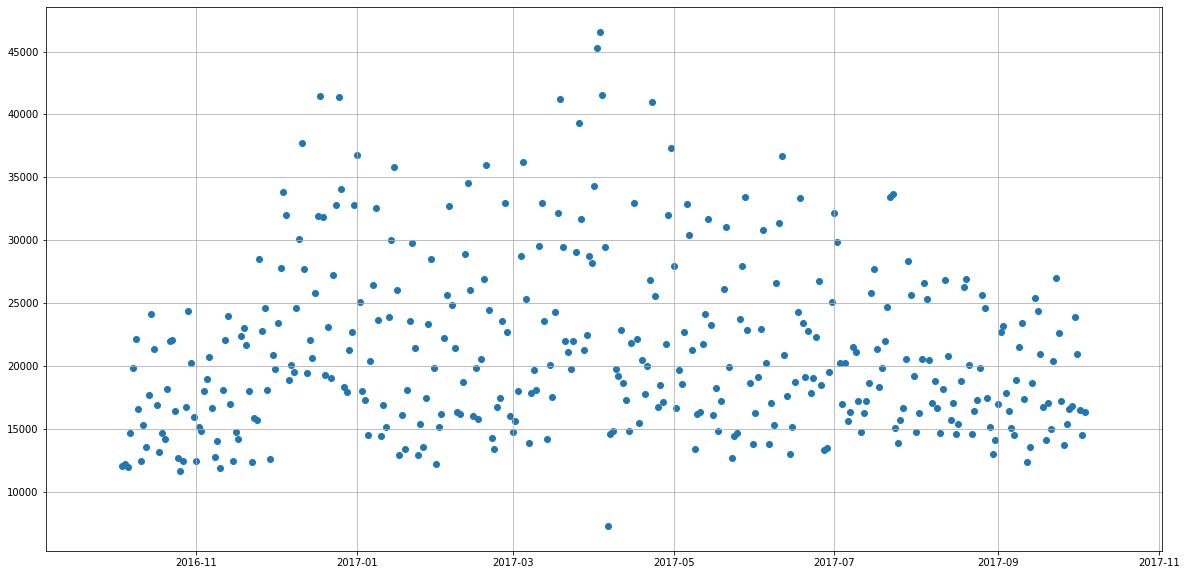

In [229]:
fig = plt.figure(figsize=(20,10))
plt.grid()
plt.scatter(gp.index, data40_70.groupby(['date'])['is_promo'].sum())
plt

In [192]:
clients_cp40_70 = clients_cp40_70.drop(['client_id'], axis=1)

In [193]:
clients_cp40_70

,gender,city,birthyear,client_id_cat
8,F,Other,1984.0,21308
14,M,Moscow,1993.0,52686
24,M,St. Petersburg,1957.0,54306
31,M,Other,1989.0,83946
36,M,Other,1989.0,77375
...,...,...,...,...
99954,M,Other,1973.0,26799
99955,F,Other,1968.0,35977
99966,M,St. Petersburg,1997.0,24426
99989,M,Other,1990.0,24615


In [205]:
data40_70

,chq_position,sales_count_x,sales_sum_x,is_promo,date,year,month,chq_id_cat,material_cat,client_id_cat,plant_cat,sales_sum_y,sales_aver_month_y,clt_mat_count
0,004,2.000,146.98,0,2016-11-01,2016,11,0,0,0,0,1634.0,1606.500000,21
1,003,1.000,249.99,1,2016-11-01,2016,11,0,1,0,0,1634.0,1606.500000,1
2,012,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0,1634.0,1606.500000,16
3,013,1.000,47.99,1,2016-11-01,2016,11,0,2,0,0,1634.0,1606.500000,16
4,011,2.000,53.98,1,2016-11-01,2016,11,0,3,0,0,1634.0,1606.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14714574,004,1.000,47.49,0,2016-10-31,2016,10,2964769,1721,27143,185,559.0,891.888889,1
14714575,002,1.000,32.99,1,2016-10-31,2016,10,2964767,1185,27143,185,105.0,891.888889,1
14714576,002,1.000,50.89,0,2016-10-31,2016,10,2964769,4896,27143,185,559.0,891.888889,26
14714577,003,1.222,23.21,1,2016-10-31,2016,10,2964769,680,27143,185,559.0,891.888889,4


In [132]:
sum_40_70 = np.array([[0] * len(date)] * (len(clients_40_70))-num_checked)
for i, client in tqdm.notebook.tqdm_notebook(enumerate(clients_40_70[i:])):
    j = 0
    for y, m in date:
        c1 = data40_70.year == y
        c2 = data40_70.month == m
        c3 = data40_70.client_id_cat==client
        chq = data40_70[c1&c2&c3].groupby(['chq_id_cat'])['sales_sum'].sum()
        if len(chq)==0:
            sum_40_70[i, j] = 0
        else:
            sum_40_70[i, j] = chq.mean()
        j += 1

KeyboardInterrupt: 

In [133]:
i

2887

In [121]:
a = np.array([[0]*3]*4)

In [341]:
dima_cp = pd.read_csv('cherrypickers.csv')

In [344]:
dima_cp = dima_cp.drop(['Unnamed: 0'], axis=1)

In [354]:
dima_weeks = dima_cp.date.unique()

In [362]:
dima_cp_next = dima_cp[['material_cat','plant_cat','price','sales_count']]
dima_cp_next = dima_cp_next.rename(columns={'price':'price_next', 'sales_count':'sales_count_next'})

In [364]:
dima_cp

,material_cat,date,plant_cat,sales_count,price,month,is_promo
0,0,2016-10-10,1,10.000,73.422000,10,0
1,3964,2016-10-10,9,0.332,200.000000,10,0
2,3964,2016-10-10,1,1.034,199.990329,10,0
3,3963,2016-10-10,297,1.000,64.990000,10,0
4,3963,2016-10-10,288,2.000,64.990000,10,0
...,...,...,...,...,...,...,...
10518185,10292,2017-10-09,116,2.000,30.990000,10,0
10518186,2521,2017-10-09,371,1.496,227.419786,10,1
10518187,70502,2017-10-09,103,1.000,249.990000,10,0
10518188,3396,2017-10-09,17,1.000,34.880000,10,1


In [377]:
dima_cp_week = dima_cp[dima_cp['date']==week]
dima_cp_next_w = dima_cp_next[dima_cp['date']==dima_weeks[i+1]]
dima_cp_week = dima_cp_week.merge(dima_cp_next_w, how='left', on=['material_cat', 'plant_cat'])
dima_cp_week['proc_price'] = (dima_cp_week['price_next']-dima_cp_week['price'])/(dima_cp_week['price'])*100
dima_cp_week['proc_sales'] = (dima_cp_week['sales_count_next']-dima_cp_week['sales_count'])/(dima_cp_week['sales_count'])*100
dima_cp_week['elasticity'] = dima_cp_week['proc_sales']/dima_cp_week['proc_price']
dima_cp_week['elasticity'] = dima_cp_week['elasticity'].fillna(0).astype(float)
inf_id = dima_cp_week['elasticity']==np.inf
mininf_id = dima_cp_week['elasticity']==-np.inf
dima_cp_week['elasticity'][inf_id] = [0]*len(inf_id)
dima_cp_week['elasticity'][mininf_id] = [0]*len(mininf_id)
dima_cp_week['elasticity'][inf_id] = [max(dima_cp_week['elasticity'])]*len(inf_id)
dima_cp_week['elasticity'][mininf_id] = [min(dima_cp_week['elasticity'])]*len(mininf_id)

for i, week in tqdm.tqdm_notebook(enumerate(dima_weeks[1:-1])):
    _dima_cp_week = dima_cp[dima_cp['date']==week]
    dima_cp_next_w = dima_cp_next[dima_cp['date']==dima_weeks[i+1]]
    _dima_cp_week = _dima_cp_week.merge(dima_cp_next_w, how='left', on=['material_cat', 'plant_cat'])
    _dima_cp_week['proc_price'] = (_dima_cp_week['price_next']-_dima_cp_week['price'])/(_dima_cp_week['price'])*100
    _dima_cp_week['proc_sales'] = (_dima_cp_week['sales_count_next']-_dima_cp_week['sales_count'])/(_dima_cp_week['sales_count'])*100
    _dima_cp_week['elasticity'] = _dima_cp_week['proc_sales']/_dima_cp_week['proc_price']
    _dima_cp_week['elasticity'] = _dima_cp_week['elasticity'].fillna(0).astype(float)
    inf_id = _dima_cp_week['elasticity']==np.inf
    mininf_id = _dima_cp_week['elasticity']==-np.inf
    _dima_cp_week['elasticity'][inf_id] = [0]*len(inf_id)
    _dima_cp_week['elasticity'][mininf_id] = [0]*len(mininf_id)
    _dima_cp_week['elasticity'][inf_id] = [max(_dima_cp_week['elasticity'])]*len(inf_id)
    _dima_cp_week['elasticity'][mininf_id] = [min(_dima_cp_week['elasticity'])]*len(mininf_id)
    dima_cp_week = pd.concat([dima_cp_week, _dima_cp_week], axis=0)
    

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWit

In [383]:
import datetime
dima_cp_week['date_next'] = pd.to_datetime(dima_cp_week['date'] )+datetime.timedelta(days=7)

In [385]:
dima_cp_week.to_csv('dima_cp.csv')

In [382]:

pd.to_datetime(dima_cp_week['date'])+datetime.timedelta(days=7)

0        2016-10-24
1        2016-10-24
2        2016-10-24
3        2016-10-24
4        2016-10-24
            ...    
181053   2017-10-09
181054   2017-10-09
181055   2017-10-09
181056   2017-10-09
181057   2017-10-09
Name: date, Length: 10479891, dtype: datetime64[ns]

In [371]:
dima_cp[['material_cat','plant_cat','date','sales_count']]

,material_cat,plant_cat,date,sales_count
0,0,1,2016-10-10,10.000
1,3964,9,2016-10-10,0.332
2,3964,1,2016-10-10,1.034
3,3963,297,2016-10-10,1.000
4,3963,288,2016-10-10,2.000
...,...,...,...,...
10518185,10292,116,2017-10-09,2.000
10518186,2521,371,2017-10-09,1.496
10518187,70502,103,2017-10-09,1.000
10518188,3396,17,2017-10-09,1.000


In [4]:
def create_client_base(transactions):
    
    def max_progress(x):
    
        m = 0
        for x_ in x:
            value = int(x_)
            if value > m:
                m = value

        return m
    
    def diff_timestamps(database):
        
        data = [0]*len(database.chq_date)

        for i in tqdm(range(1, len(database.chq_date))):
    
            if database.client_id[i] != database.client_id[i - 1]:
                data[i - 1] = pd.Timestamp('2017-10-04') - database.chq_date[i - 1]
            else:
                data[i - 1] = database.chq_date[i] - database.chq_date[i - 1]
    
        data[-1] = pd.Timestamp('2017-10-04') - database.chq_date[len(database.chq_date) - 1]
        
        database['time_diff'] = data
        
        database['time_diff'] = pd.to_numeric(database['time_diff'].dt.days, downcast='integer')
        
    local_data = transactions.groupby(['client_id', 'chq_date'])
    
    data = local_data['chq_position'].progress_apply(max_progress).reset_index(name='max_pos')
    data['max_promo'] = local_data['is_promo'].sum().reset_index(name='max_promo')['max_promo']
    data['max_sales'] = local_data['sales_sum'].sum().reset_index(name='sales_sum')['sales_sum']
    
    diff_timestamps(data)
    
    local_data = data.groupby(['client_id'])['time_diff'].max().reset_index(name='time_max')
    data = pd.merge(data, local_data, how='left', on='client_id')
    
    local_data = data.groupby(['client_id'])['time_diff'].mean().reset_index(name='time_mean')
    data = pd.merge(data, local_data, how='left', on='client_id')
    
    data['is_quit'] = (((data.time_max / data.time_mean) > 5) | (data.time_max > 21)).astype(int)
    
    return data

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime as dt
from ipywidgets import interact
from tqdm.notebook import tqdm

In [6]:
transactions = transactions.sort_values('chq_date')

In [7]:
database = create_client_base(transactions)

AttributeError: 'SeriesGroupBy' object has no attribute 'progress_apply'